In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import wrds
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats
import janitor 
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

import statsmodels.api as sm

In [50]:
data = pd.read_pickle("data99.pkl")

In [51]:
data00 = data.copy()

In [52]:
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

def calculate_portfolio_returns(data, portfolios,var,weight):
    result = pd.DataFrame()

    for portfolio in portfolios:
        subset = data[data[portfolio] == 1]
        result[portfolio] = subset.groupby('jdate').apply(wavg, var, weight)
    result['all_vwret'] = data.groupby('jdate').apply(wavg, var, weight)

    for portfolio in portfolios:
        result[portfolio + '_excess'] = result[portfolio] - result['all_vwret']

    portfolio_return = result.reset_index()
    return portfolio_return

portfolios = ['MV', 'BV', 'SV', 'MG', 'BG', 'SG']

portfolio_beme = calculate_portfolio_returns(data00,portfolios,'beme','me')

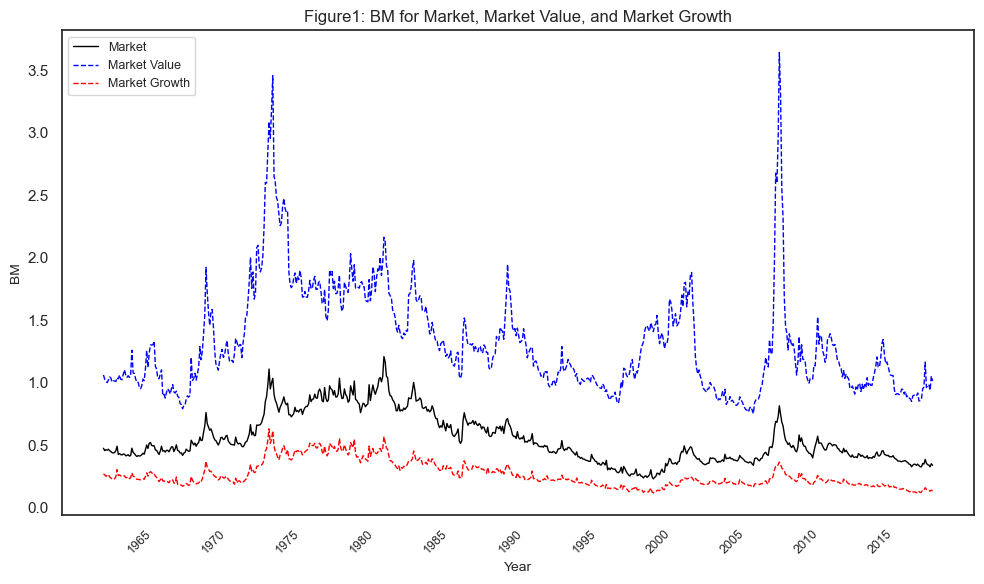

In [53]:
######### Figure 1 #########

sns.set(style="white", font_scale=1)
plt.figure(figsize=(10, 6))
sns.lineplot(x='jdate', y='all_vwret', data=portfolio_beme, label='Market', color='black', linewidth=1, linestyle='-')
sns.lineplot(x='jdate', y='MV', data=portfolio_beme, label='Market Value', color='blue', linewidth=1, linestyle='--')
sns.lineplot(x='jdate', y='MG', data=portfolio_beme, label='Market Growth', color='red', linewidth=1, linestyle='--')
plt.title('Figure1: BM for Market, Market Value, and Market Growth', fontsize=12)
plt.xlabel('Year', fontsize=10)
plt.ylabel('BM', fontsize=10)
plt.legend(loc='upper left', fontsize=9)
start_year = 1965
end_year = portfolio_beme['jdate'].dt.year.max()
years = pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-12-31', freq='5Y')
plt.xticks(years, years.year, rotation=45, fontsize=9)
plt.tight_layout()
plt.show()

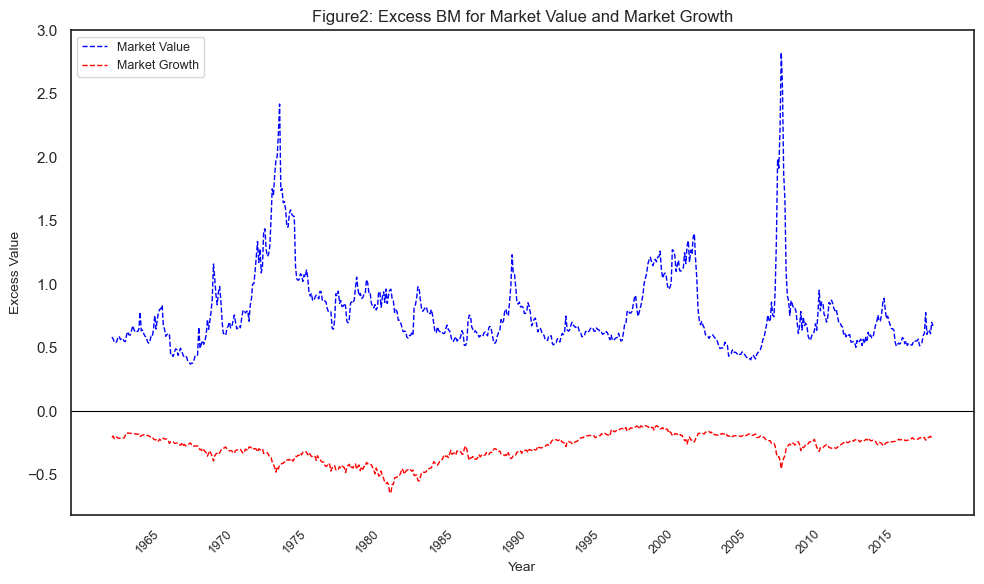

In [54]:
######### Figure 2 #########

sns.set(style="white", font_scale=1)
plt.figure(figsize=(10, 6))
plt.plot(portfolio_beme['jdate'], portfolio_beme['MV_excess'], label='Market Value', color='blue', linestyle='--', linewidth=1)
plt.plot(portfolio_beme['jdate'], portfolio_beme['MG_excess'], label='Market Growth', color='red', linestyle='--', linewidth=1)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
plt.title('Figure2: Excess BM for Market Value and Market Growth', fontsize=12)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Excess Value', fontsize=10)
plt.legend(loc='upper left', fontsize=9)
start_year = 1965
end_year = portfolio_beme['jdate'].dt.year.max()
years = pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-12-31', freq='5Y')
plt.xticks(years, years.year, rotation=45, fontsize=9)
plt.tight_layout()
plt.show()

In [41]:
data = pd.read_pickle("data99.pkl")

In [42]:
def summary(data, portfolio):
    portfolio_name = portfolio + '_excess'
    _data00 = data[portfolio_name]
    _data00 = _data00

    mean = _data00.mean()  
    var = _data00.var(ddof=1)  
    sd = var ** 0.5  
    n = len(_data00)  
    se = (var / n) ** 0.5 
    t_stat_diff = mean / se 

    result = pd.DataFrame(
        [
            mean ,  
            sd ,   
            # t_stat_diff  
        ],
        # index=['Average Excess Return', 'Standard Deviation', 't-Statistic'],
        index=['Average Excess Return', 'Standard Deviation'],
        columns=[portfolio]
    )

    return result

In [43]:
portfolio_beme00 = portfolio_beme.copy()
portfolio_beme00['post_dummy'] = (portfolio_beme00['jdate'] <= '1991-06-30').astype(int)
subset = portfolio_beme00.copy()
subset00 = portfolio_beme00[portfolio_beme00['post_dummy']==1].reset_index(drop=True)
subset11 = portfolio_beme00[portfolio_beme00['post_dummy']==0].reset_index(drop=True)
subset99 = subset00 - subset11

In [44]:
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan


# def calculate_statistics(dataset,portfolios,variable,weight):
#     result = pd.DataFrame()

#     for portfolio in portfolios:
#         subset = dataset[dataset[portfolio] == 1]
#         result[portfolio] = subset.groupby('jdate').apply(lambda x: wavg(x, variable, weight))
    
#     result['all_vwret'] = dataset.groupby('jdate').apply(lambda x: wavg(x, variable, weight))

#     for portfolio in portfolios:
#         result[portfolio + '_excess'] = result[portfolio] - result['all_vwret']

#     excess_returns = result[[portfolio + '_excess' for portfolio in portfolios]]
#     mean_excess_returns = excess_returns.mean()
#     std_deviation = excess_returns.std()   
#     # t_statistic = mean_excess_returns / (std_deviation / np.sqrt(excess_returns.count()))

#     final_result = pd.DataFrame(
#         [
#             mean_excess_returns.values,  
#             std_deviation.values ,      
#             # t_statistic.values              
#         ],
#         index=['Average Excess Beme', 'Standard Deviation'],
#         columns=portfolios
#     )
#     return final_result.round(2), result

# portfolios = ['MV', 'BV', 'SV', 'MG', 'BG', 'SG']

In [45]:
result00 = pd.concat(
    [summary(subset, portfolio=portfolio) for portfolio in portfolios], 
    axis=1
).round(2)

result11 = pd.concat(
    [summary(subset00, portfolio=portfolio) for portfolio in portfolios], 
    axis=1
).round(2)

result22 = pd.concat(
    [summary(subset11, portfolio=portfolio) for portfolio in portfolios], 
    axis=1
).round(2)

result33 = pd.concat(
    [summary(subset99, portfolio=portfolio) for portfolio in portfolios], 
    axis=1
).round(2)

table1_panelA = pd.concat([result00,result11,result22,result33], axis=0)
table1_panelA

,MV,BV,SV,MG,BG,SG
Average Excess Return,0.78,0.73,0.96,-0.28,-0.28,-0.28
Standard Deviation,0.31,0.28,0.40,0.10,0.10,0.12
Average Excess Return,0.81,0.77,0.99,-0.35,-0.35,-0.34
Standard Deviation,0.31,0.28,0.34,0.10,0.09,0.13
Average Excess Return,0.74,0.70,0.93,-0.22,-0.22,-0.21
Standard Deviation,0.30,0.26,0.44,0.05,0.05,0.06
Average Excess Return,0.07,0.07,0.06,-0.13,-0.13,-0.12
Standard Deviation,0.34,0.30,0.46,0.10,0.10,0.13


In [46]:
variables = ['all_vwret', 'MV', 'MG', 'SV', 'SG', 'BV', 'BG']
subset = portfolio_beme00[variables]
corr_matrix = subset.corr()
corr_matrix00 = pd.DataFrame(corr_matrix.iloc[0, 1:].round(2)).T

variables = ['MV_excess', 'MG_excess', 'SV_excess', 'SG_excess', 'BV_excess', 'BG_excess']
subset = portfolio_beme00[variables]
corr_matrix11 = subset.corr().round(2)
corr_matrix11.columns = corr_matrix11.columns.str.replace('_excess', '')
corr_matrix11.index = corr_matrix11.index.str.replace('_excess', '')

corr_matrix = pd.concat([corr_matrix00, corr_matrix11])
corr_matrix.index.values[0] = 'Cor(R, RM)'

In [47]:
table2_panelB = corr_matrix
print(table2_panelB)

              MV    MG    SV    SG    BV    BG
Cor(R, RM)  0.75  0.96  0.66  0.84  0.78  0.97
MV          1.00 -0.31  0.96 -0.08  1.00 -0.32
MG         -0.31  1.00 -0.27  0.93 -0.34  1.00
SV          0.96 -0.27  1.00 -0.07  0.94 -0.29
SG         -0.08  0.93 -0.07  1.00 -0.11  0.92
BV          1.00 -0.34  0.94 -0.11  1.00 -0.35
BG         -0.32  1.00 -0.29  0.92 -0.35  1.00


In [48]:
def autocorrelations(data, columns, max_lag=12):
    autocorr_df = pd.DataFrame(index=range(1, max_lag + 1), columns=columns)
    
    for col in columns:
        for lag in range(1, max_lag + 1):
            autocorr_df.loc[lag, col] = data[col].shift(lag).corr(data[col])
    
    return autocorr_df
columns = ['MV', 'BV', 'SV', 'MG', 'BG', 'SG']
autocorr_result = autocorrelations(portfolio_beme00, columns)
autocorr_result = autocorr_result.apply(pd.to_numeric, errors='coerce')
table2_panelC = autocorr_result.round(2)
print(table2_panelC)


      MV    BV    SV    MG    BG    SG
1   0.97  0.97  0.96  0.97  0.98  0.97
2   0.92  0.93  0.90  0.96  0.96  0.95
3   0.88  0.88  0.85  0.94  0.94  0.93
4   0.83  0.84  0.79  0.92  0.93  0.91
5   0.78  0.79  0.73  0.91  0.91  0.89
6   0.74  0.75  0.68  0.89  0.90  0.87
7   0.70  0.71  0.64  0.88  0.89  0.85
8   0.67  0.68  0.61  0.88  0.88  0.84
9   0.64  0.66  0.58  0.87  0.87  0.83
10  0.62  0.63  0.56  0.86  0.87  0.81
11  0.60  0.61  0.53  0.85  0.86  0.80
12  0.58  0.60  0.51  0.86  0.86  0.81


In [49]:
portfolio_beme.to_pickle('portfolio_beme.pkl')